In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

#import Husimi   # quantum routines
import Harp     # Classical integration routines
import importlib  # for reloading routines

In [ ]:
#importlib.reload(Harp)  # if you need to reload it!

## drifting the perturbed classical Harper model

Should we integrate an orbit without drifting. 
Then use all the points as initial conditions for drifting?

In [2]:
# routines for classical drifting system integration 

twopi = 2.0*np.pi

# parameters $a,b,\epsilon,\mu, \mu_p$ all can drift

# dy/dt = func(y,t), needed for integrator!
# note that y[0] = phi and y[1] = p
def cfunc_dr(y,tau,parms0,d_parmsdt):
    parms = parms0 + d_parmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    mu = parms[3]
    mup = parms[4]
    return [a*np.sin(y[1] - b) ,\
                -eps*np.sin(y[0]) - mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]

# not used really
# at time tau, what is the energy value?
def H_classical_dr(p,phi,tau,parms0,d_parmsdt):
    #phi = y[0]; p = y[1]
    parms = parms0 + d_parmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    mu = parms[3]
    mup = parms[4]
    return a*(1.0 - np.cos(p-b)) - eps*np.cos(phi)\
        - mu*np.cos(phi-tau) - mup*np.cos(phi+tau)

# return unperturbed energy value from position in phase space
# neglect tau, mu, mu' but keep b
def H0_classical(p,phi,parms0): 
    a = parms0[0]
    b = parms0[1]
    eps = parms0[2]
    return a*(1.0 - np.cos(p-b)) - eps*np.cos(phi)
    
# modulo so an array of angles is in [-pi,pi]
def respi(z_arr):
    phi_arr = z_arr%twopi # so that it is in [0:2pi]
    ii = phi_arr >np.pi
    phi_arr[ii]-= twopi # now phi is in [-pi,pi]
    return phi_arr
    

# integrate at a period, the forced pendulum 
# arguments:
#   y0: is initial conditions, 
#   npoints: is number of points we want
#   parms = [a,b,epsilon, mu, mup]: are parameters of the Hamiltonian model at tau=0
#   d_parmsdt = time derivatives of all parameters 
#   points of output are at times 0 + 2 pi n, integer n up to npoints 
#   integrate to every 2 pi period, npoints returned including initial condition 
# returns: phi,p arrays of integrated points 
# this particular routine does all times at once by sending a set of times to the integrator
def givepoints_arr_dr(y0,npoints,parms0,d_parmsdt):
    # set up time array, every 2pi/nu so for period of perturbation
    step  = 2.0*np.pi
    stop = step*npoints
    time  = np.arange(0.0,stop,step)  # time array for outputs  goes from 0 to stop-step 
    #                              with increment step, does not reach stop. 
    #time += taushift  # shift time vector 
    # do the integration
    y = odeint(cfunc_dr, y0, time, args=(parms0,d_parmsdt))
    phi_arr = np.squeeze(y[:,0])  # is an array of phi at different times
    p_arr = np.squeeze(y[:,1])    # is an array of momenta at different times
    
    phi_arr = respi(phi_arr)  # so that phi in [-pi:pi]
    p_arr   = respi(p_arr) # so that p is in [-pi,pi]
    
    return phi_arr,p_arr 

colorlist = ['black','blue','green','magenta','orange','gold','blueviolet','springgreen','dodgerblue'] # 'red',

In [3]:

# For each one of the phase space points in the list (could be an orbit), 
# drift the system and record final position after nperiods
# phi_arr,p_arr: phase space initial conditions (arrays of points)
# nperiods: how many periods to drift
# parms0 parametesr at tau=0
# d_parmsdt drift rate 
# returns end points of each orbit 
# no plots
def nper(phi_arr,p_arr,nperiods,parms0,d_parmsdt):
    phi_arr_end = phi_arr*0
    p_arr_end   = p_arr*0
    for k in range(len(phi_arr)):
        y0 = np.array([phi_arr[k],p_arr[k]])
        phi_arr_d,p_arr_d  = givepoints_arr_dr(y0,nperiods,parms0,d_parmsdt)
        p_arr_end[k] = p_arr_d[-1]
        phi_arr_end[k] = phi_arr_d[-1]
    return phi_arr_end,p_arr_end

# for each of the phase space points in the list, integrate orbits 
# and store all intermediate points at each period 
# this will help us compute things like expectation value of energy h0
# return full arrays of all orbits as well as only the end points 
def store_all_points(phi_arr,p_arr,nperiods,parms0,d_parmsdt):
    nn = len(phi_arr)
    phi_store = np.zeros((nn,nperiods))
    p_store =  np.zeros((nn,nperiods))
    for k in range(nn):
        y0 = np.array([phi_arr[k],p_arr[k]])
        phi_arr_d,p_arr_d  = givepoints_arr_dr(y0,nperiods,parms0,d_parmsdt)
        phi_store[k,:] = phi_arr_d
        p_store[k,:] = p_arr_d
        
    phi_arr_end = np.squeeze(phi_store[-1,:])
    p_arr_end   = np.squeeze(p_store[-1,:])
    return phi_store, p_store,phi_arr_end, p_arr_end

# compute unperturbed energy values mean and standard deviations for orbits 
# assuming parms are not drifting, ignores mu, mu', tau 
def h0stats(phi_arr,p_arr,parms0):
    hvals = H0_classical(p_arr,phi_arr,parms0)
    mu = np.mean(hvals)
    sig = np.std(hvals)
    return mu, sig

# compute h0 stats for 2d arrays which record surface of section orbits post drift 
def h0stats_2darrs(phi_store,p_store,parms0):
    nn = phi_store.shape[0]  # numbers of orbits
    mu_arr = np.zeros(nn)
    sig_arr = np.zeros(nn)
    for k in range(nn):
        phi_arr = np.squeeze(phi_store[k,:])
        p_arr = np.squeeze(p_store[k,:])
        mu, sig = h0stats(phi_arr,p_arr,parms0)
        mu_arr[k] = mu
        sig_arr[k] = sig
    return mu_arr,sig_arr

# no longer used 
# plot in phase space the beginning orbit and end points after drifting
# inputs: two sets of phase space positions
# the second set can be shifted in momentum space by delta_p if you desire
# beginning points are plotted in red, end points in blue
# no computations, only plotting 
def plt_beg_end(phi_arr_beg,p_arr_beg,phi_arr_end,p_arr_end,delta_p):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    #i = np.random.randint(low=0,high =len(colorlist))  # random colors 
    # plot beginning orbits in red 
    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=1)
    pshift = respi(p_arr_end - delta_p) # shift momentum
    # plot end points in blue 
    ax.scatter(phi_arr_end,pshift,s=1.0,edgecolor='none',facecolor='blue',lw=1)
    plt.show()

# compute and plot orbits of a set of points in phase space 
# the idea is these are finally positions after drifting 
# we want to compute the orbits now freezing the parameters so see where they ended up
# inputs:
#   phi_arr_end, p_arr_end: phase space positions after drifting, initial conditions for a new orbit set 
#   parms_end: parameters at the end of the drift : we freeze the parameters at these values
#   npoints: how many new points to compute in a surface of section that is computed with the frozen parameters
#   delta_p: shift in moment for the display of the newly computed orbits 
#   phi_arr_beg, p_arr_beg an additional set of phase space positions to plot (initial conditions prior to drifting)
# outputs: a plot showing initial conditions in red, and resulting surface of section generated from points postdrift
def mkend_plot(phi_arr_end,p_arr_end,parms_end,npoints,delta_p,phi_arr_beg,p_arr_beg):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])
    
    for k in range(len(phi_arr_end)):  #each point in phase sapce 
        y0 = np.array([phi_arr_end[k],p_arr_end[k]])  #initial conditions 
        phi_arr,p_arr = givepoints_arr_dr(y0,npoints,parms_end,parms_end*0)  # compute orbits, frozen parms

        pshift = respi(p_arr - delta_p) # display with momentum shift
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        ax.scatter(phi_arr,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=1)  # plot them 

    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=1)  # plot also these points, not shifted 
    plt.show()


# plot a surface of section (frozen parameters) along with another set of points in phase space 
# phi_arr_beg, p_arr_beg: are a set of points in phase space to plot in red
# parms0: are a set of parameters, frozen
# npoints, norbits: compute npoints of norbits with randomly chosen initial conditions integrated 
#   with the frozen parameter set
# and plot this surface of section  
# delta_p lets you shift p if you want to 
def mksurf(phi_arr_beg,p_arr_beg,parms0,norbits,npoints,delta_p,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.text(2.6,-3.9,r'$\phi$',fontsize=14)
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    #delta_p = 0.0
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    for k in range(norbits):
        phi0 = np.random.uniform(low=-np.pi,high=np.pi)
        p0 = np.random.uniform(low=-np.pi,high=np.pi)
        y0 = [phi0,p0]
        phi_arr,p_arr = givepoints_arr_dr(y0,npoints,parms0,parms0*0)  # compute orbits, frozen parms
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        pshift = respi(p_arr - delta_p)
        ax.scatter(phi_arr,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=0.5)  # plot them 
      
    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=0.5)  # plot also these points, not shifted 

    if (len(ofile)>2):
        ofile_l = froot + '_sf.png'
        plt.savefig(ofile_l,dpi=200)
    plt.show()

# is like routine mkend_plot but using stored arrays for the orbits 
def mkend_plot2(phi_arr_beg,p_arr_beg,phi_store,p_store,delta_p,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.text(2.6,-3.9,r'$\phi$',fontsize=14)
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    norbits = p_store.shape[0]
    for k in range(norbits):
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        pshift = respi(np.squeeze(p_store[k,:]) - delta_p)
        phi = np.squeeze(phi_store[k,:])
        ax.scatter(phi,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=0.5)  # plot them 
      
    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=0.5)  # plot also these points, not shifted 
    
    if (len(ofile)>2):
        ofile_l = froot + '_endsf.png'
        plt.savefig(ofile_l,dpi=200)
        
    plt.show()
    


In [58]:
# class definition for a drifting classical system 
class drift_sys():
    def __init__(self,parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot):
        self.parms0 = parms0  # [a,b,eps,mu,mup] parameters 
        self.d_parmsdt = d_parmsdt  # rate of drift parameters  for [a,b,eps,mu,mup]
        self.y0 = y0  # initial condition for a particular orbit in form [phi0,p0]
        self.npoints_in = npoints_in  # number of points in initial condition orbit (no drift) 
        self.npoints_sf = npoints_sf  # numbers of points in each orbit of initial surface of section (to figure)
        self.norbits = norbits  #  number of orbits in initial surface of section 
        self.nperiods = nperiods  # drift periods, how long to drift 
        self.froot = froot   # a string which we can later use to construct figures 
        self.parms_end = self.parms0 + self.nperiods*2*np.pi*self.d_parmsdt  # compute final params after drift 
        self.Delta_b = self.parms_end[1] - self.parms0[1] # compute difference in b values if b is drifting
        if (self.Delta_b != 0):
            print('Delta_b = {:.3f}'.format(self.Delta_b))
        if (len(self.y0) < 2):
            print("Error: y0 should be a point in phase space (2d array)")

    # integrate the initial orbit with initial conditions y0 in phase space (not drifting)
    # the number of points in the orbit is n_points_in
    def mkbegs(self):
        self.phi_arr_beg,self.p_arr_beg = givepoints_arr_dr(self.y0,self.npoints_in,self.parms0,self.parms0*0.0)

    # show the initial orbit on a surface of section 
    # This routine integrates norbits with randomly chosen initial conditions and each one has npoints_sf
    # then the result is plotted 
    def surf(self,ofile):
        try:
            self.phi_arr_beg
        except AttributeError:
            print('error2: you need to run mkbegs first')
        else:
            mksurf(self.phi_arr_beg,self.p_arr_beg,self.parms0,self.norbits,self.npoints_sf,0.0,ofile)

    # make a surface of section for the post drift parameters (not drifting)
    # points are chosen randomly in phase space, initial conditions are ignored
    def surf_end(self,ofile):
        mksurf([],[],self.parms_end,self.norbits,self.npoints_sf,self.Delta_b,ofile)
        
    # drift the initial orbit, store the resulting end points, then integrate those with frozen parameters
    # and show the results 
    def dodrift(self,ofile):
        # do the drift nperiods worth 
        try:
            self.phi_arr_beg
        except AttributeError: 
            print('error1: you need to run mkbegs first')
        else:
            self.phi_arr_end,self.p_arr_end = nper(self.phi_arr_beg,self.p_arr_beg,self.nperiods,self.parms0,self.d_parmsdt)
        
            # compute surface of section from final positions of orbits 
            self.phi_store_end, self.p_store_end,phi_junk, p_junk = \
                store_all_points(self.phi_arr_end,self.p_arr_end,self.npoints_sf,self.parms_end,self.d_parmsdt*0)
            # show results!
            mkend_plot2(self.phi_arr_beg,self.p_arr_beg,self.phi_store_end,self.p_store_end,self.Delta_b,ofile) 
            # plot post drift orbits along with initial conditions
 
    # compute the energy states for a set of points in phase space using the unperturbed hamiltonian 
    def h0stats(self):
        # compute energies stats for final surface of section 
        try:
            self.phi_store_end
        except AttributeError: 
            print('error: phi_store_end does not exist yet, dodrift first')
        else:
            self.mu_arr, self.sig_arr = h0stats_2darrs(self.phi_store_end,self.p_store_end,self.parms_end)
        try:
            self.phi_store_endr
        except AttributeError:
            x=1
        else: 
            self.mu_arr_r, self.sig_arr_r = h0stats_2darrs(self.phi_store_endr,self.p_store_endr,self.parms0)

    # let's reverse the drift!
    def reverse(self,ofile):
        # reverse the drift by flipping dparms/dt and starting with parms_end
        # and using the end points
        try: 
            self.phi_arr_end
        except AttributeError: 
            print('error: you need to run dodrift first')
        else: 
            self.phi_arr_endr,self.p_arr_endr = nper(self.phi_arr_end,self.p_arr_end,self.nperiods,self.parms_end,-1*self.d_parmsdt)

            # compute surface of section from final positions of orbits 
            self.phi_store_endr, self.p_store_endr,phi_junk, p_junk = \
                store_all_points(self.phi_arr_endr,self.p_arr_endr,self.npoints_sf,self.parms0,self.d_parmsdt*0)
            # show results!
            mkend_plot2(self.phi_arr_beg,self.p_arr_beg,self.phi_store_endr,self.p_store_endr,0.0,ofile) 
        

In [7]:
a = 5.; b=0; eps=0.5; mu=0.1; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
npoints_in = 150;  # number of points for initial conditions orbit, predrift 
y0 = np.array([0,1])   # for computing the initial orbit, its initial condition
npoints_sf=150 # to make a surface of section plot at the beginning, predrift  
norbits = 100  # number of orbits in initial surface of section plot 
ofile = ''
froot = ''

db_dt = 2e-3  # drift rate in b 
d_parmsdt = np.array([0.0,db_dt,0,0,0])  # only b drifting 
nperiods = 150 # numbers of periods for drifting
dsim1 = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

fac = 15 # drift way faster 
db_dt = 2e-3*fac  # drift rate in b 
d_parmsdt = np.array([0.0,db_dt,0,0,0])  
nperiods = int(150/fac) 
dsim2 = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

fac = 0.5 # drift slower 
db_dt = 2e-3*fac  
d_parmsdt = np.array([0.0,db_dt,0,0,0])  
nperiods = int(150/fac) 
dsim3 = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)



Delta_b = 1.885
Delta_b = 1.885
Delta_b = 1.885


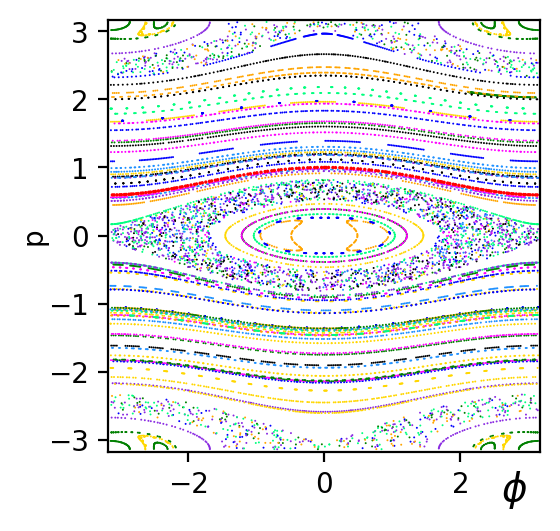

In [8]:
dsim1.mkbegs()  # make the initial orbit 
dsim1.surf(ofile) # show initial surface of section, optionally
# along with initial orbit in red

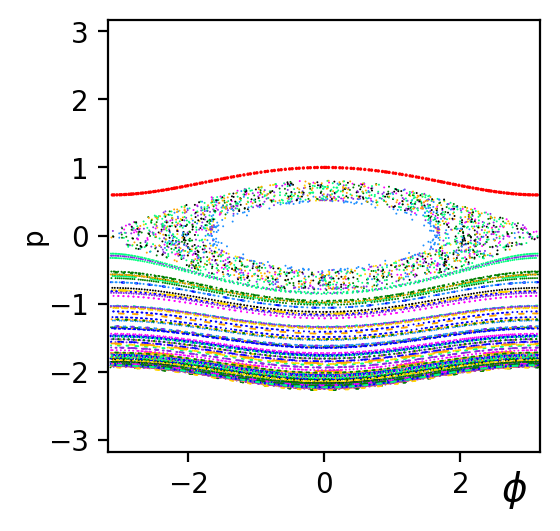

In [9]:
dsim1.dodrift(ofile) # do drift, showing resulting surf section computed after drift along with initial orbit
dsim1.h0stats() # some stats computed from unperturbed hamiltonian

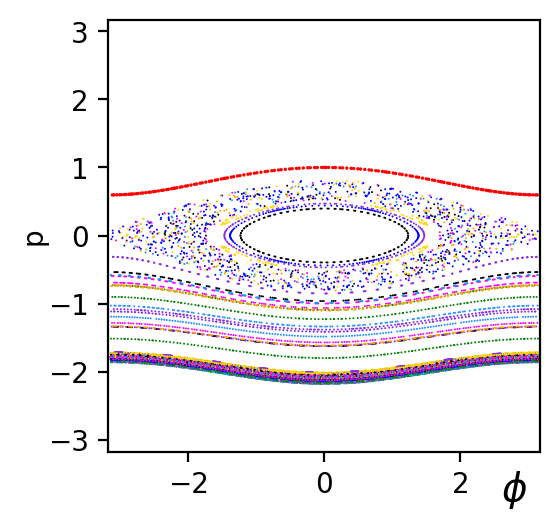

In [10]:
dsim2.mkbegs()  # make the initial orbit 
dsim2.dodrift(ofile) # do the drifting 
dsim2.h0stats()  # compute stats of h0

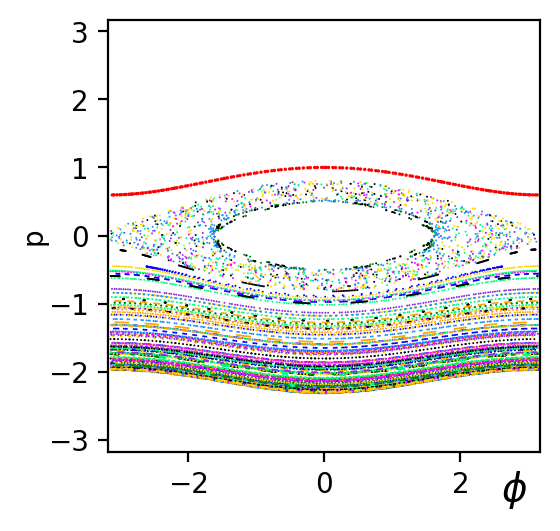

In [11]:
dsim3.mkbegs()  # make the initial orbit 
dsim3.dodrift(ofile) # do the drifting 
dsim3.h0stats()  # compute stats of h0

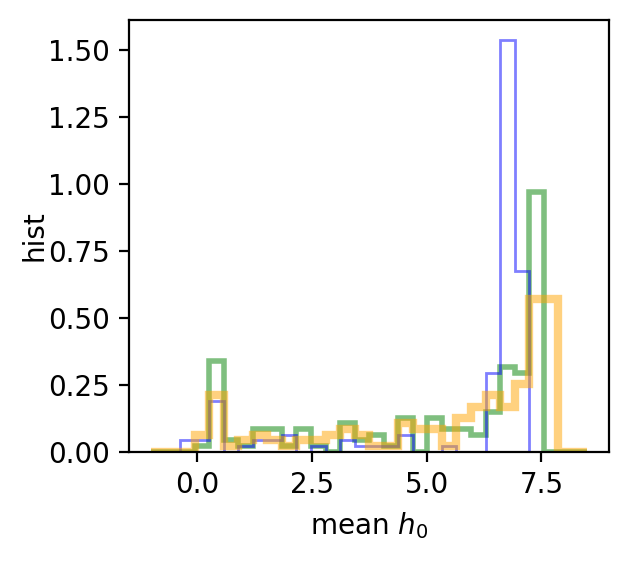

In [12]:
# compare stats of <h0>
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
ax.set_ylabel('hist',labelpad=0)
ax.set_xlabel(r'mean $h_0$')

nbins=30
brange = [-1,8.5]

hist1, bin_edges = np.histogram(dsim1.mu_arr,range=brange,bins=nbins,density=True)
hist2, bin_edges = np.histogram(dsim2.mu_arr,range=brange,bins=nbins,density=True)
hist3, bin_edges = np.histogram(dsim3.mu_arr,range=brange,bins=nbins,density=True)

ax.stairs(hist1, bin_edges,color='green'  ,alpha=0.5,lw=2)
ax.stairs(hist2, bin_edges,color='blue'   ,alpha=0.5,lw=1)  # fast  drift 
ax.stairs(hist3, bin_edges,color='orange' ,alpha=0.5,lw=3)  # slow  drift

plt.show()

In [200]:
# some difference here, rapid drift most stuff jumps across

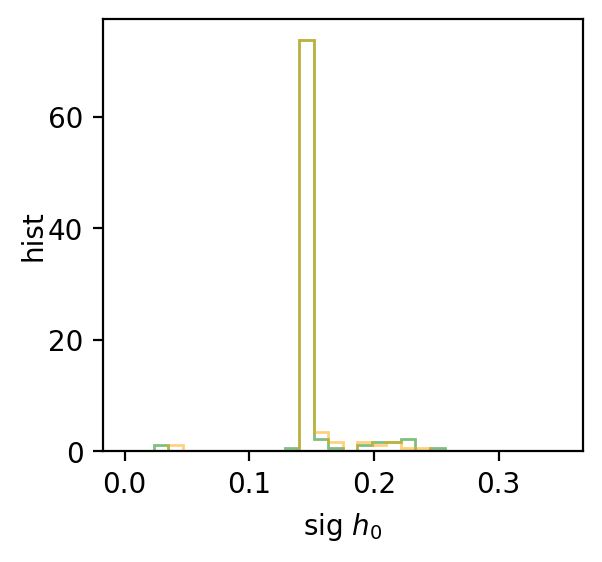

In [205]:
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
ax.set_ylabel('hist',labelpad=0)
ax.set_xlabel(r'sig $h_0$')

nbins=30
brange = [0,0.35]

hist1, bin_edges = np.histogram(dsim1.sig_arr,range=brange,bins=nbins,density=True)
hist2, bin_edges = np.histogram(dsim2.sig_arr,range=brange,bins=nbins,density=True)
hist3, bin_edges = np.histogram(dsim3.sig_arr,range=brange,bins=nbins,density=True)

#ax.stairs(hist1, bin_edges,color='blue'  ,alpha=0.5)
ax.stairs(hist2, bin_edges,color='green'  ,alpha=0.5)
ax.stairs(hist3+0, bin_edges,color='orange'  ,alpha=0.5)

plt.show()

# is skinny because most orbits have left chaotic regions 

In [13]:
a = 5.; b=0; eps=0.5; mu=0.2; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
npoints_in = 150;  # number of points for initial conditions orbit, predrift 
y0 = np.array([0,1])   # for computing the initial orbit, its initial condition
npoints_sf=150 # to make a surface of section plot at the beginning, predrift  
norbits = 100  # number of orbits in initial surface of section plot 
ofile = ''
froot = ''

db_dt = 2e-3  # drift rate in b 
d_parmsdt = np.array([0.0,db_dt,0,0,0])  # only b drifting 
nperiods = 150 # numbers of periods for drifting!!!!!
dsim1b = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

fac = 15 # drift way faster 
db_dt = 2e-3*fac  
d_parmsdt = np.array([0.0,db_dt,0,0,0])  
nperiods = int(150/fac) 
dsim2b = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

fac = 0.5 # drift slower 
db_dt = 2e-3*fac   
d_parmsdt = np.array([0.0,db_dt,0,0,0])  
nperiods = int(150/fac) 
dsim3b = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

Delta_b = 1.885
Delta_b = 1.885
Delta_b = 1.885


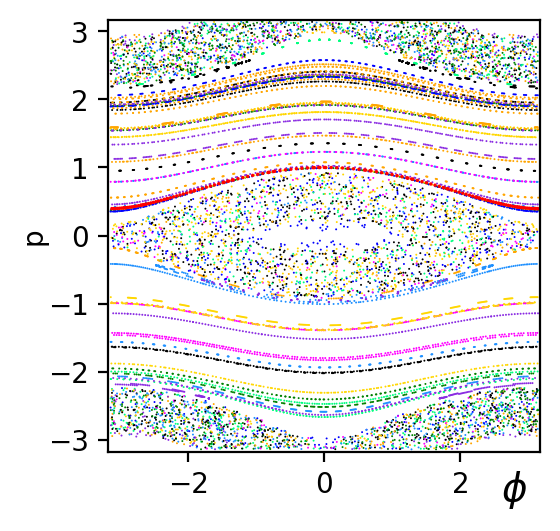

In [14]:
dsim1b.mkbegs()  # make the initial orbit 
dsim1b.surf(ofile) # show initial surface of section, optionally
# along with initial orbit in red

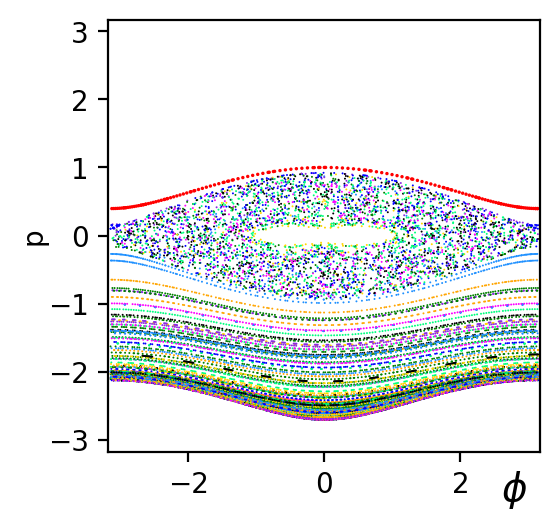

In [15]:
dsim1b.dodrift(ofile) # do the drifting 
dsim1b.h0stats()  # compute h0 stats

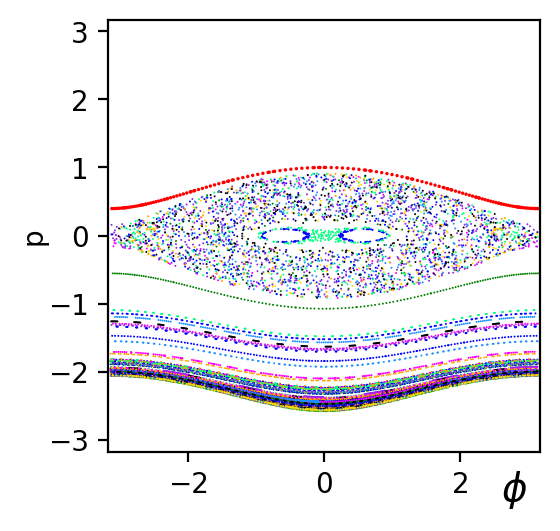

In [16]:
dsim2b.mkbegs()  # make the initial orbit 
dsim2b.dodrift(ofile) # do the drifting 
dsim2b.h0stats()

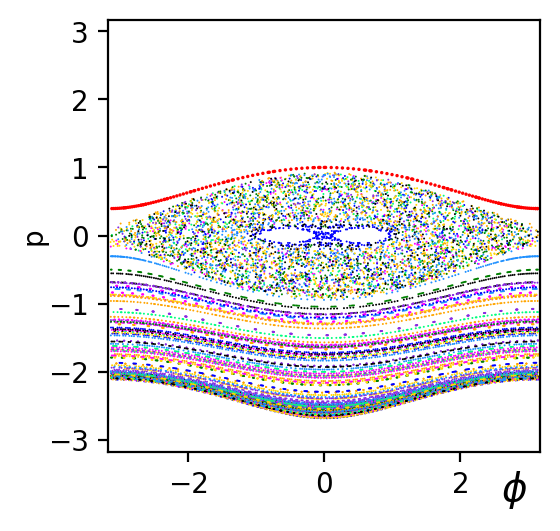

In [17]:
dsim3b.mkbegs()  # make the initial orbit 
dsim3b.dodrift(ofile) # do the drifting 
dsim3b.h0stats()

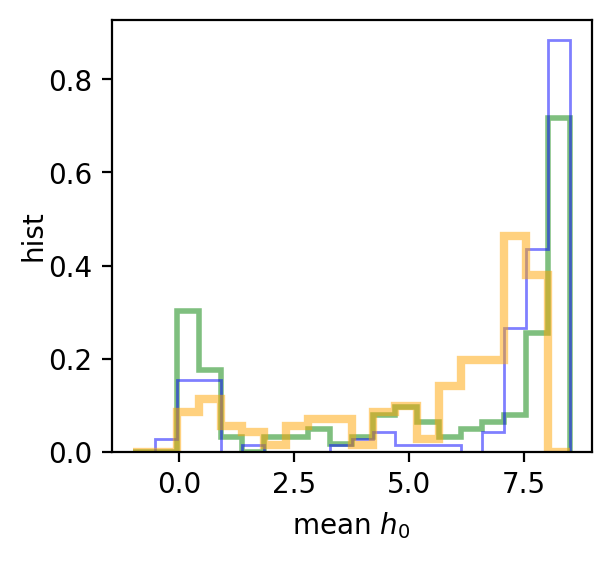

In [219]:
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
ax.set_ylabel('hist',labelpad=0)
ax.set_xlabel(r'mean $h_0$')

nbins=20
brange = [-1,8.5]

hist1, bin_edges = np.histogram(dsim1b.mu_arr,range=brange,bins=nbins,density=True)
hist2, bin_edges = np.histogram(dsim2b.mu_arr,range=brange,bins=nbins,density=True)
hist3, bin_edges = np.histogram(dsim3b.mu_arr,range=brange,bins=nbins,density=True)

ax.stairs(hist1, bin_edges,color='green'  ,alpha=0.5, lw=2)
ax.stairs(hist2, bin_edges,color='blue'  ,alpha=0.5,lw=1)   # fast 
ax.stairs(hist3+0.0, bin_edges,color='orange'  ,alpha=0.5,lw=3)  #slow!

plt.show()

In [ ]:
#orange is slow

In [59]:
a = 5.; b=0; eps=0.5; mu=0.0; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
npoints_in = 150;  # number of points for initial conditions orbit, predrift 
y0 = np.array([0,0.7])   # for computing the initial orbit, its initial condition
npoints_sf=150 # to make a surface of section plot at the beginning, predrift  
norbits = 100  # number of orbits in initial surface of section plot 
ofile = ''
froot = ''

db_dt = 0.0 # drift rate in b 
dmu_dt = 1e-3
d_parmsdt = np.array([0.0,db_dt,0,dmu_dt,dmu_dt])  # only drifting mu,mup
nperiods = 150 # numbers of periods for drifting
dsim1c = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods,froot)

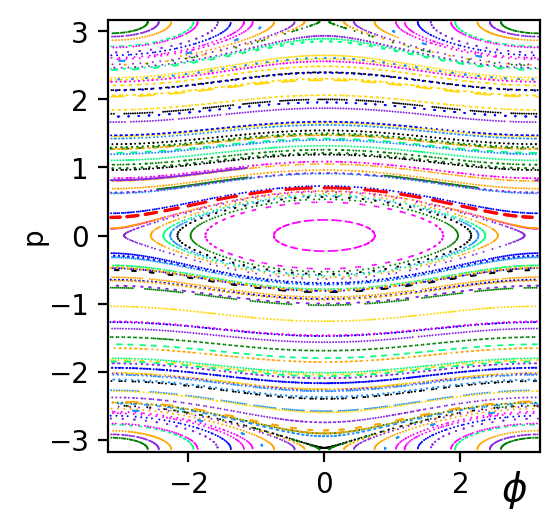

In [60]:
dsim1c.mkbegs()  # make the initial orbit 
dsim1c.surf(ofile) # show initial surface of section, optionally
# along with initial orbit in red

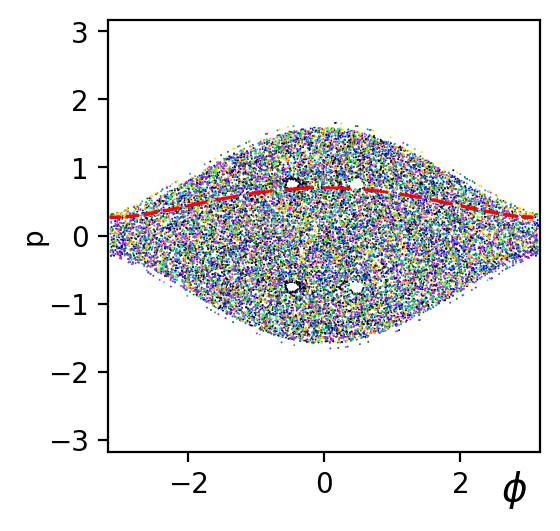

In [61]:
dsim1c.dodrift(ofile) # do the drifting 


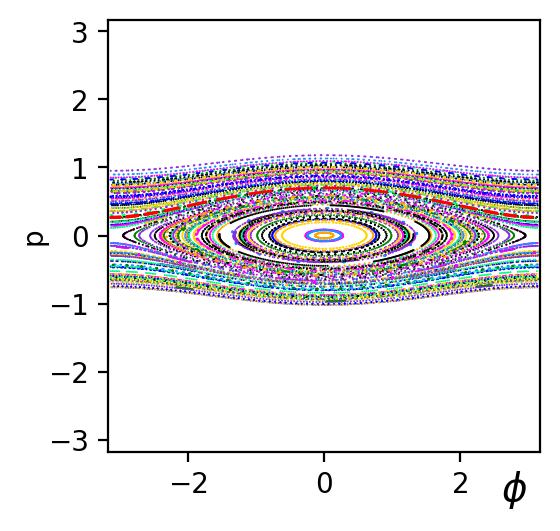

In [62]:
dsim1c.reverse(ofile) # go the opposite direction

In [63]:
dsim1c.h0stats()

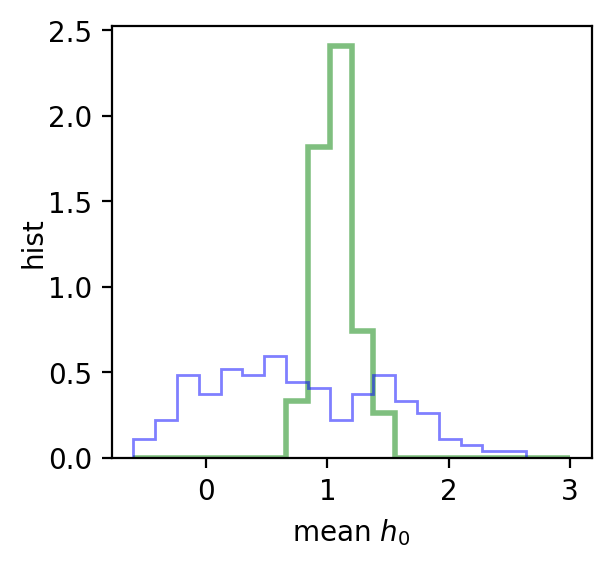

In [69]:
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
ax.set_ylabel('hist',labelpad=0)
ax.set_xlabel(r'mean $h_0$')

nbins=20
brange = [-0.6,3.0]

hist1, bin_edges = np.histogram(dsim1c.mu_arr,range=brange,bins=nbins,density=True)
hist2, bin_edges = np.histogram(dsim1c.mu_arr_r,range=brange,bins=nbins,density=True)
#hist3, bin_edges = np.histogram(dsim3b.mu_arr_r,range=brange,bins=nbins,density=True)

ax.stairs(hist1, bin_edges,color='green'  ,alpha=0.5, lw=2)
ax.stairs(hist2, bin_edges,color='blue'  ,alpha=0.5,lw=1)   # fast 
#ax.stairs(hist3+0.0, bin_edges,color='orange'  ,alpha=0.5,lw=3)  #slow!

plt.show()
# green is all chaotic and so the same mean energy, though the dispersion would be high

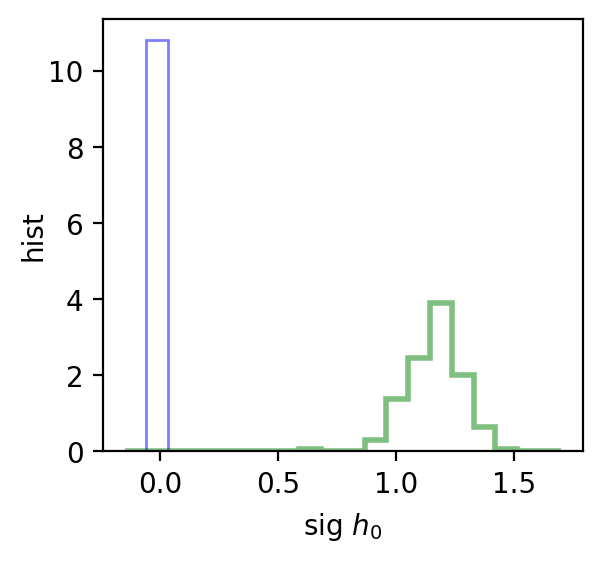

In [74]:
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
ax.set_ylabel('hist',labelpad=0)
ax.set_xlabel(r'sig $h_0$')

nbins=20
brange = [-0.15,1.7]

hist1, bin_edges = np.histogram(dsim1c.sig_arr,range=brange,bins=nbins,density=True)
hist2, bin_edges = np.histogram(dsim1c.sig_arr_r,range=brange,bins=nbins,density=True)
#hist3, bin_edges = np.histogram(dsim3b.mu_arr_r,range=brange,bins=nbins,density=True)

ax.stairs(hist1, bin_edges,color='green'  ,alpha=0.5, lw=2)
ax.stairs(hist2, bin_edges,color='blue'  ,alpha=0.5,lw=1)   # fast 
#ax.stairs(hist3+0.0, bin_edges,color='orange'  ,alpha=0.5,lw=3)  #slow!

plt.show()
# green is all chaotic and so large dispersion, blue is not chaotic at the end

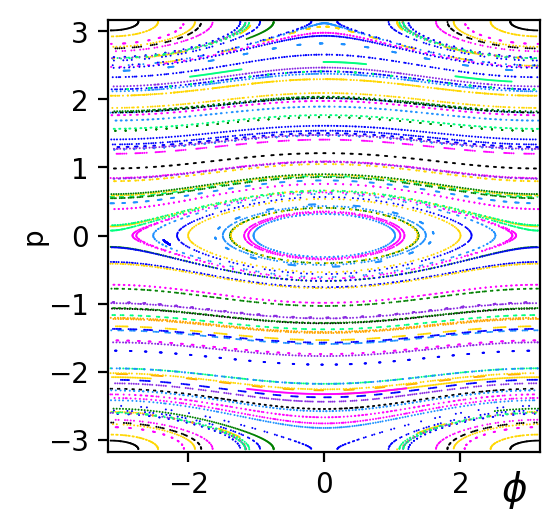

In [75]:
mksurf([],[],parms0,norbits,npoints_sf,0.0,'')